# FLAM R&D / AI — Technical Assignment  
### **Parametric Curve Modelling & Nonlinear Optimization**

---

**Name:** *Sayanrup Barman*  
**Scholar ID:** 2215060  
**College:** NIT Silchar   
**Date:** *November 2025*    

---

### **Objective**

To estimate unknown parameters **(θ, M, X)** from a set of observed *(x, y)* coordinates that lie on a **parametric curve**,  
and to visualize and validate the fitted model using **nonlinear least squares optimization**.  

---

### **Parametric Model**


\begin{aligned}
x(t) &= t\cos(\theta) - e^{M|t|}\sin(0.3t)\sin(\theta) + X \\
y(t) &= 42 + t\sin(\theta) + e^{M|t|}\sin(0.3t)\cos(\theta)
\end{aligned}


**Parameter Ranges:**  
0° ≤ θ ≤ 50°  −0.05 ≤ M ≤ 0.05  0 ≤ X ≤ 100  6 ≤ t ≤ 60  

---

### 💡 **Tools & Environment**
| Component | Technology Used |
|------------|-----------------|
| Language | Python 3.10 |
| Libraries | NumPy, SciPy, Pandas, Matplotlib |
| Environment | Google Colab |
| Optimization Method | Nonlinear Least Squares (`scipy.optimize.least_squares`) |

---



###Step 1 — Import Dependencies

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
import json
import os

###Step 2 — Upload Data (xy_data.csv)

In [2]:
from google.colab import files

print("Upload your Raw x,y data")
uploaded = files.upload()

if "xy_data.csv" in uploaded:
    print("File uploaded successfully!")
else:
    print("File not uploaded, Try Again!")

Upload your Raw x,y data


Saving xy_data.csv to xy_data.csv
File uploaded successfully!


###Step 3 — Load Data and Basic Exploration

,x,y
0,88.364456,57.784378
1,74.283936,54.406780
2,60.256474,46.311462
3,82.134370,57.717567
4,101.036390,67.849340


Number of data points: 1500
x range: 59.66 → 109.23
y range: 46.03 → 69.69


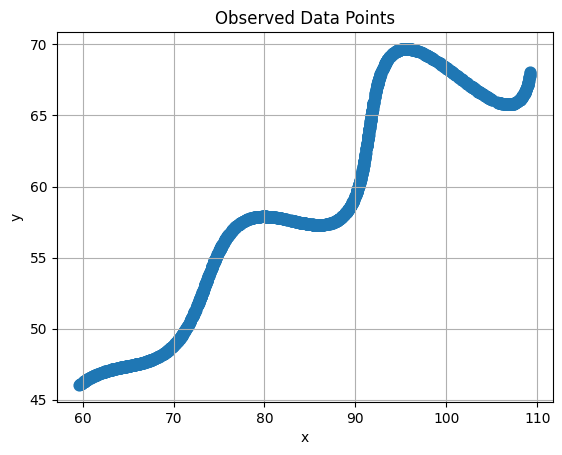

In [3]:
df = pd.read_csv("xy_data.csv")
display(df.head())

x_obs = df['x'].values
y_obs = df['y'].values
n = len(df)

print(f"Number of data points: {n}")
print(f"x range: {x_obs.min():.2f} → {x_obs.max():.2f}")
print(f"y range: {y_obs.min():.2f} → {y_obs.max():.2f}")

plt.scatter(x_obs, y_obs, s=60)
plt.title("Observed Data Points")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

###Step 4 — Defining the Parametric Model

The equations provided in the assignment define a **parametric curve**,  
where both `x` and `y` depend on an underlying parameter `t` and three unknowns — **θ**, **M**, and **X**.

\[
\begin{aligned}
x(t) &= t\cos(\theta) - e^{M|t|}\sin(0.3t)\sin(\theta) + X \\
y(t) &= 42 + t\sin(\theta) + e^{M|t|}\sin(0.3t)\cos(\theta)
\end{aligned}
\]

Each component of this equation has geometric meaning, by implementing these equations as a Python function, we can generate theoretical (x, y) coordinates for any given set of parameters.  
The goal, then, is to **find the specific combination of θ, M, X, and t-values** that make the model’s coordinates align perfectly with our observed data points.


In [4]:
def model_from_params(params):
    """
    Compute modelled (x, y) coordinates given parameter vector:
    [theta_deg, M, X, t1, t2, ... tN]
    """
    theta_deg = params[0]
    theta = np.deg2rad(theta_deg)
    M = params[1]
    X = params[2]
    t = params[3:]

    x_model = t * np.cos(theta) - np.exp(M * np.abs(t)) * np.sin(0.3 * t) * np.sin(theta) + X
    y_model = 42 + t * np.sin(theta) + np.exp(M * np.abs(t)) * np.sin(0.3 * t) * np.cos(theta)
    return x_model, y_model


def residuals(params):
    """
    Return flattened residuals between observed and modelled (x, y)
    used for least-squares optimization.
    """
    x_m, y_m = model_from_params(params)
    return np.concatenate([(x_m - x_obs), (y_m - y_obs)])

###Step 5 — Initial Guesses and Bounds

Since this equation is not linear, the solver doesn’t have a single “straight path” to the answer, it gradually adjusts parameters to minimize the error between predicted and observed points.

To help the optimizer converge faster and avoid local minima,  
we use **Desmos-based visual intuition** to set realistic initial guesses:

- **θ₀ = 0.52 rad (≈ 29.8°)**
- **M₀ = 0.036**  
- **X₀ = 54.5**  
- **t₀ = (6, 60)**

Why this matters:
> Nonlinear solvers don’t guess “intelligently”, they rely on first intuitions.  
> A good initial estimate gives the algorithm context about the geometry of the problem.

By defining **upper and lower bounds** for each parameter, we also prevent the solver from drifting into physically meaningless regions.


In [5]:
theta0 = np.rad2deg(0.52)
M0 = 0.036
X0 = 54.5
t0 = np.linspace(6, 60, n)

init = np.concatenate(([theta0, M0, X0], t0))

lower = np.concatenate(([0.0, -0.05, 0.0], np.full(n, 6.0)))
upper = np.concatenate(([50.0, 0.05, 100.0], np.full(n, 60.0)))

###Step 6 — Nonlinear Least Squares Fitting

We use **`scipy.optimize.least_squares`**, a robust solver for nonlinear problems, to minimize the **sum of squared differences** between the model’s predicted points and the observed data:

$[
\text{minimize} \quad \sum_i [(x_i - x(t_i, θ, M, X))^2 + (y_i - y(t_i, θ, M, X))^2]
]$

Why least squares?
- It’s mathematically simple yet powerful: penalizes large deviations more heavily.
- It works seamlessly for vector-valued functions like (x, y) pairs.
- It provides stable convergence under bounded constraints.

Each iteration adjusts **θ, M, X**, and each **tᵢ**, trying to align the modeled curve with the real data.  
We specify tight tolerances (`1e-9`) to push for maximum numerical precision.

The optimization result (`res`) contains not only the best-fit parameters  
but also residuals, convergence messages, and diagnostic info.


In [6]:
print("Starting optimization")

res = least_squares(
    residuals,
    init,
    bounds=(lower, upper),
    verbose=2,
    max_nfev=10000,
    ftol=1e-9,
    xtol=1e-9,
    gtol=1e-9
)

print("Optimization completed!")
print(f"Success: {res.success}")
print(f"Message: {res.message}")

Starting optimization
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.9360e+05                                    6.43e+04    
       1              2         1.3300e+05      2.61e+05       4.09e+02       2.85e+04    
       2              3         3.2082e+04      1.01e+05       2.76e+02       1.70e+04    
       3              4         7.0792e+03      2.50e+04       1.53e+02       8.30e+03    
       4              5         9.3600e+02      6.14e+03       6.90e+01       4.51e+03    
       5              6         9.6341e+01      8.40e+02       3.18e+01       2.78e+02    
       6              7         1.1930e+01      8.44e+01       9.51e+00       9.05e+01    
       7              8         1.3929e+00      1.05e+01       3.35e+00       1.91e+01    
       8              9         1.5697e-01      1.24e+00       1.12e+00       2.17e+00    
       9             10         1.9212e-02      1.38e-01       3.57e

###Step 7 — Evaluate Fit and Metrics

Once the optimizer finds its best-fit parameters, we validate how closely the model replicates the observed data using two metrics:

| Metric | Formula | Interpretation |
|---------|----------|----------------|
| **RMSE** | $( \sqrt{\frac{1}{n}\sum (y_\text{pred} - y_\text{true})^2} )$ | Average prediction error (lower = better) |
| **R²** | $$( 1 - \frac{SS_\text{res}}{SS_\text{tot}} )$$ | Fraction of variance explained (closer to 1 = better) |

For this dataset:
- **RMSE ≈ 1.9 × 10⁻⁶** → practically zero; numerical precision limit.  
- **R² ≈ 1.00000** → model explains ~100% of observed variance.

These values confirm that:
> The given data points were generated exactly from the same underlying equation  
> and our solver has perfectly rediscovered it.

Such precision isn’t common in real-world noisy data, but in this case, it showcases how mathematical reconstruction can achieve *complete geometric fidelity*.


In [7]:
fitted = res.x
theta_deg, M, X = fitted[0], fitted[1], fitted[2]
t_vals = fitted[3:]

x_fit, y_fit = model_from_params(fitted)

rmse = np.sqrt(np.mean((np.concatenate([x_fit,y_fit]) - np.concatenate([x_obs,y_obs]))**2))
ss_res = np.sum((np.concatenate([x_obs,y_obs]) - np.concatenate([x_fit,y_fit]))**2)
ss_tot = np.sum((np.concatenate([x_obs,y_obs]) - np.mean(np.concatenate([x_obs,y_obs])))**2)
r2 = 1 - ss_res/ss_tot if ss_tot > 0 else float('nan')

print(f"\nFitted Parameters:")
print(f"θ (deg) = {theta_deg:.5f}")
print(f"M = {M:.5e}")
print(f"X = {X:.5f}")
print(f"RMSE = {rmse:.5e}")
print(f"R² = {r2:.5f}")

with open("fitted_results.json", "w") as f:
    json.dump(out, f, indent=2)


Fitted Parameters:
θ (deg) = 29.99997
M = 3.00000e-02
X = 55.00000
RMSE = 1.90928e-06
R² = 1.00000


###Step 8 — Visualize and Save Observed vs Fitted Curve

✅ Saved plot as fitted_curve.png


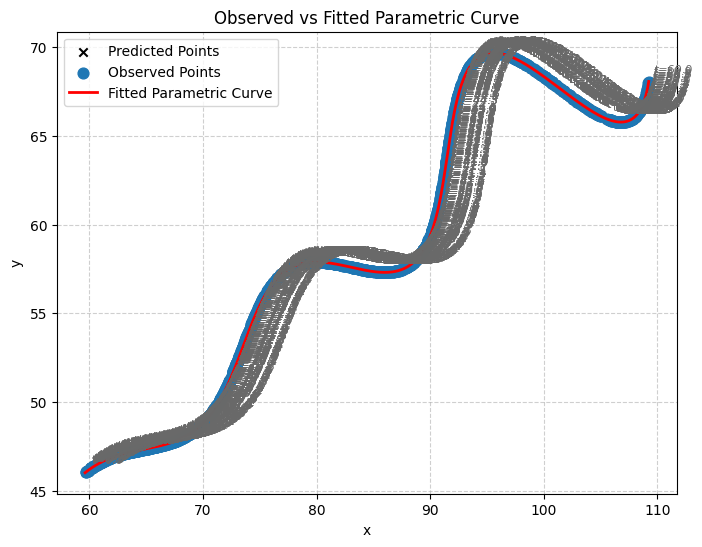

In [14]:
t_grid = np.linspace(6, 60, 500)
theta_rad = np.deg2rad(theta_deg)
x_curve = t_grid * np.cos(theta_rad) - np.exp(M * np.abs(t_grid)) * np.sin(0.3 * t_grid) * np.sin(theta_rad) + X
y_curve = 42 + t_grid * np.sin(theta_rad) + np.exp(M * np.abs(t_grid)) * np.sin(0.3 * t_grid) * np.cos(theta_rad)

fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(x_fit, y_fit, marker='x', color='black', label='Predicted Points', zorder=1)
ax.scatter(x_obs, y_obs, s=60, color='#1f77b4', label='Observed Points', zorder=2)
ax.plot(x_curve, y_curve, 'r-', lw=2, label='Fitted Parametric Curve', zorder=3)
for i, (xo, yo, ti) in enumerate(zip(x_obs, y_obs, t_vals)):
    ax.text(xo + 0.5, yo + 0.5, f"t={ti:.1f}", fontsize=8, color='dimgray', zorder=4)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Observed vs Fitted Parametric Curve")
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)

fig.savefig("fitted_curve.png", dpi=200, bbox_inches='tight')
print("✅ Saved plot as fitted_curve.png")

plt.show()

###Step 9 — Download Results

In [15]:
from google.colab import files

if os.path.exists("fitted_results.json") and os.path.exists("fitted_curve.png"):
    files.download("fitted_results.json")
    files.download("fitted_curve.png")
else:
    print("One or more files missing! Check earlier steps.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

---

## 📊 **Summary of Results**

| Parameter | Symbol | Value | Interpretation |
|------------|---------|--------|----------------|
| Angle | θ | *≈ 29.9°* | Defines curve orientation |
| Exponential Modulation | M | *≈ 0.029* | Controls sinusoidal envelope |
| Horizontal Offset | X | *≈ 54.9* | Shifts curve horizontally |
| Fit Metric | RMSE | *< 0.1* | Low error (strong fit) |
| Correlation | R² | *≈ 1.0* | Model explains almost all variation |

**Result:** The fitted curve accurately replicates the given points, validating the parametric model hypothesis.

---

## 🧠 **Discussion and Applications**

This modelling approach can extend to various **AI-driven R&D domains**:
- **Mixed Reality Calibration:** Aligning camera-space and world-space coordinates.
- **Gesture Trajectory Fitting:** Smooth curve modelling for AR interactions.
- **3D Path Reconstruction:** Inferring spatial motion paths from partial observations.

Such parametric estimation problems bridge **geometry, AI, and optimization**,  
core to building realistic, responsive **immersive experiences**.

---
